In [20]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
from scipy.integrate import odeint
from scipy.signal import argrelextrema
import numdifftools as nd

#class for a single molecule species
class Species:
    # initialize species, make it aware of parent reaction system
    def __init__(self, system, name, constant=False):
        # system of the species 
        self.system = system
        self.name = name
        self.constant = constant
        
        # equation which describes the first time derivative of the species 
        self.equation = "0"
        # components of the different reactions, which constitute the time derivative
        self.components = ["0"]
        # function dt(X,P) which returns the calculated gradient
        self.dt = None
        
        self.generateFunction()
        
    # generate time derivative from components
    def generateFunction(self):
        self.equation = 'lambda X, P: ' + " + ".join(self.components)
        self.dt = eval(self.equation)
        
class Run: 
    def __init__(self,t,solution, model):
        self.time = t
        self.solution = solution
        self.model = model
        
    def plot(self, speciesToPlot, axis, *args, **kwargs):
        for i, species in enumerate(self.model.species):
            if species.name in speciesToPlot:
                axis.plot(self.time,self.solution[:,i], label=species.name, **kwargs)
                
    def stabilityThreshold(self):
        stable = np.array([])
        idx = np.arange(0, len(self.time)-1, 5)
        for i in idx[1:]:
            X = self.solution[i,:]
            time = self.time[i]
            
            stable = np.append(stable,self.analyzeStability(X,time))
   
        
        unstableIndices = np.where(stable==0)[0]
        unstable = np.max(unstableIndices) if len(unstableIndices) > 0 else 0
        return self.time[unstable*5]
        
        
    def analyzeStability(self,X,t):
        jacobianF = nd.Jacobian(model.dX)
        jacobian = jacobianF(X,t,np.array(self.model.parameters))
        eig_values, eig_vectors = np.linalg.eig(jacobian)
        negReal = np.where(eig_values < 0)[0]
        zero = np.where(eig_values == 0)
        """
        print("===== STABILITY ANALYSIS =====\nThe stability analysis is only valid for steady states. \n")
        print("Jacobian at time={} ".format(self.time[-1]) )
        print(jacobian)
        
        print("\n")
        print("Eigen values")
        print(eig_values)
        print("\n")
        print("Eigen vectors")
        print(eig_vectors)
        print("\n")
        
        
        
        print(len(negReal),len(eig_values))
        
        if len(negReal) == len(eig_values):
            print("All eigenvalues have negative real parts, \nthe steady state is asymptotically stable")
        else:
            print("Not all eigenvalues have negative real parts, \nthe steady state is unstable") 
        """
        return len(negReal) == len(eig_values)
    def printStability(self):
        jacobianF = nd.Jacobian(self.model.dX)
        jacobian = jacobianF(self.solution[-1,:],self.time[-1],np.array(self.model.parameters))
        print("===== STABILITY ANALYSIS =====\nThe stability analysis is only valid for steady states. \n")
        print("Jacobian at time={} ".format(self.time[-1]) )
        print(jacobian)
        eig_values, eig_vectors = np.linalg.eig(jacobian)
        print("\n")
        print("Eigen values")
        print(eig_values)
        print("\n")
        print("Eigen vectors")
        print(eig_vectors)
        print("\n")
        
        negReal = np.where(eig_values < 0)[0]
        zero = np.where(eig_values == 0)
        
        print(len(negReal),len(eig_values))
        
        if len(negReal) == len(eig_values):
            print("All eigenvalues have negative real parts, \nthe steady state is asymptotically stable")
        else:
            print("Not all eigenvalues have negative real parts, \nthe steady state is unstable") 
            
        return len(negReal) == len(eig_values)
        
class Model:
    def __init__(self):
        self.species = []
        self.parameters = []
        self.reactions = []
        self.loaded = False
        
    def getSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return s
        print("getSpecies error: species " + name + " was not found")
        return None
    
    def indexSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return i
        print("indexSpecies error: species " + name + " was not found")
        return None
        
    def addSpecies(self, name, *args, **kwargs):
        self.species.append(Species(self, name, *args, **kwargs))
        
    def addReaction(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        
        reaction = {
            "id": reaction_id, 
            "type": "stoichometric", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "k"})
        self.parameters.append(k[0])
        
        self.reactions.append(reaction)
        
        parameter = "P[{}]".format(len(self.parameters)-1)
        
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        order = len(kinetic_dependencies)
        
        nth = " * " if order > 0 else ""
        v = parameter + nth +  "*".join(species)
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addMichaelisKinetics(self, reactants, stoichometry, k,kinetic_dependencies, reaction_id, reaction_comment):
        
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetics", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": [],
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        self.parameters.append(k[0])
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        self.parameters.append(k[1]) #K_m
        
        self.reactions.append(reaction)
        
        V_max = "P[{}]".format(len(self.parameters)-2)
        K_m = "P[{}]".format(len(self.parameters)-1)
        
        limiting_substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        nth = " * " if len(kinetic_dependencies) > 0 else ""               
        
        v = V_max + nth +  "*".join(species) + " * " + limiting_substrate + " /(" + K_m + " + " +  limiting_substrate + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def addHillKinetics(self, reactants, stoichometry, k, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "hill-enzyme-kinetic", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": [],
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) #hill_coefficent
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_a"})
        K_a = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) #K_a
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "hill coefficient"})
        hill_coefficent = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) #k_cat
        
        self.reactions.append(reaction)
        
        
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        nth = " * " if len(kinetic_dependencies) > 0 else ""
        
        v = V_max + nth +  "*".join(species) + " *(" + substrate + "**" +  hill_coefficent + ")/(" + K_a + "**" + hill_coefficent + " + "+ substrate + "**" +  hill_coefficent + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addInhibitonKinetics(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetic with noncompetetive inhibition", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) 
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        K_m = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) 
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_i"})
        K_i = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) 
        
        self.reactions.append(reaction)
        
        inhibitor = "X[{}]".format(self.indexSpecies(kinetic_dependencies[0]))
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies[1:]]
        nth = " * " if len(kinetic_dependencies) > 1 else ""
        
        v = V_max + nth +  "*".join(species) + " * " + substrate + " /((" + K_m + " + " +  substrate + ")"
        v += " *(1+" + inhibitor +"/"+ K_i +"))" 
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addActivationKinetics(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetic with allosteric activation", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) #k_cat
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        K_m = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) #K_m
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_a"})
        K_a = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) #K_i
        
        self.reactions.append(reaction)
        
        activator = "X[{}]".format(self.indexSpecies(kinetic_dependencies[0]))
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies[1:]]
        nth = " * " if len(kinetic_dependencies) > 1 else ""
        
        v = V_max + nth +  "*".join(species) + " * " + substrate +"*" + activator +" /((" + K_m  + "+" +substrate+" )*( "+ K_a + "+" + activator+ "))"
    
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def dX(self, X,t, P):
        dX = np.array([species.dt(X,P) for species in self.species])
        return dX
    
    def load(self, path):
        if self.loaded:
            print("warning: model will be overwritten")
            self.species = []
            self.parameters = []
                  
        with open (path, "r") as myfile:
            data=myfile.readlines()
    
        reaction_id = 0
        # read model from system definition
        for i, line in enumerate(data):
            #remove newline and spaces
            line = line.strip("\n")
            


            # match first line for species definition
            if i == 0:
                species_match = re.findall('\$?[A-Z]+', line)
                if species_match:
                    for species in species_match:
                        if species[0] == "$":
                            self.addSpecies(species[1:], constant=True)
                        else:
                            self.addSpecies(species)
                else:
                    print("error: no species found in first line of system definition")

            #match consecutive lines for reaction equations
            else:
                if len(line) > 0 and line[0] != "#":
                    
                                   
                    reaction_match = re.findall(r"(.+)?-([A-Z])-(.*)->([0-9A-Z+ ]+)?(?:#(.*))?$",line)
                   
                    
                    if len(reaction_match) > 0:
                        reaction_id += 1
                        
                        educts = reaction_match[0][0]
                        reaction_type = reaction_match[0][1]
                        reaction_constants = reaction_match[0][2]
                        products = reaction_match[0][3]
                        
                        reaction_comment = reaction_match[0][4] 
                        
                        
                        
                        #match reaction constants and dependencies
                        constants = re.findall("(\d*\.?\d+)", reaction_constants)

                        if(len(constants) > 0):
                            constants = [float(i) for i in constants]
                            kinetic_dependencies = re.findall('[0-9]*[A-Z]+', reaction_constants)
                            reaction_order = len(kinetic_dependencies)

                        else: 
                             print("error: reaction constant was missing")

                        #match products and educts
                        educt_species = re.findall('[0-9]*[A-Z]+', educts)
                        product_species = re.findall('[0-9]*[A-Z]+', products)
                    
                        reactants = []
                        stoichometry = []

                        for educt in educt_species:

                            s = re.findall('[0-9]+', educt)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', educt)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] -= N
                            else:
                                reactants.append(name)
                                stoichometry.append(-N)

                        for product in product_species:

                            s = re.findall('[0-9]+', product)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', product)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] += N
                            else:
                                reactants.append(name)
                                stoichometry.append(N)

                        #stoichometric reaction        
                        if reaction_type == "S":

                            self.addReaction(reactants,stoichometry,constants, reactants[:len(educt_species)], reaction_id, reaction_comment)      

                        #reaction with michaelis menten kinetics
                        if reaction_type == "M":

                            if len(educt_species) > 1:
                                print("warning: michaelis menten kinetics with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")

                            self.addMichaelisKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)      
                            
                            
                        #reaction with hill kinetics
                        if reaction_type == "H":
                            if len(educt_species) > 1:
                                print("warning: hill kinetic with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")
                                
                            self.addHillKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)
                            
                            print(reactants,stoichometry,constants,kinetic_dependencies)
                        
                        #michaelis menten kinetics with allosteric inhibition
                        if reaction_type == "I":
                            if len(educt_species) > 1:
                                print("warning: inhibitory kinetic with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")
                                
                            self.addInhibitonKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)
                            
                        #michaelis menten kinetics with allosteric activation
                        if reaction_type == "A":
                           
                                
                            self.addActivationKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)
        
    #move to simulation run class
    def simulate(self,X0,duration):
        t = np.linspace(0,duration,200)
        solution = odeint(self.dX,X0,t,args=(self.parameters,))
        
        
        return(Run(t,solution,self))
    
    def explain(self):
        print("===== ODE Kinetic model  =====\n")
        print("the following species were defined: \n")
        
        for species in self.species:
            print("{:<8}".format(species.name))
            
                
        
        print("\nthe following reactions were defined:")
        
        for reaction in self.reactions:
            print("\n{}: ".format(reaction["id"]) + reaction["type"])
            print(reaction["description"])
            print("reaction partner :" + ", ".join(reaction["reactants"]))
            print("stoichometry     :" + ", ".join(str(x) for x in reaction["stoichometry"]))
            print("dependency       :" + ", ".join(reaction["kinetic_dependencies"]))
            print("parameters       :")
            
            for parameter in reaction["parameters"]:
                print("   {:<6}".format(parameter["name"]) + ": {}".format(self.parameters[parameter["id"]]))
                
class Sampler():
    def __init__(self, model):
        self.model = model
        
    def plotFunctionFamily(self, X0, t,  parameter ,A , speciesToPlot):
        parsave = self.model.parameters[parameter]
        # map colormap to parameter scale
        cmap = mpl.cm.get_cmap('viridis')  
        parcolor = lambda p: cmap((p-A[0])/(A[-1]-A[0])) 
        
        fig, axes = plt.subplots(nrows=len(speciesToPlot), sharex=True)
        
        
        fig.set_size_inches(15,3*len(speciesToPlot))
    
        axes[-1].set_xlabel("simulation time")        
            
        norm = mpl.colors.Normalize(vmin=A[0],vmax=A[-1])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        #fig.tight_layout()
        fig.subplots_adjust(top=1-0.3/len(speciesToPlot))
        cbar_ax = fig.add_axes([0.13,0.98, 0.5, 0.03/len(speciesToPlot)])
        
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=cbar_ax,orientation='horizontal')
        cbar.ax.set_xlabel("parameter")

        for i, currentSpecies in enumerate(speciesToPlot):
            axes[i].set_ylabel(currentSpecies)                      

            for p in A:                
                
                # Hier kann dann noch ne schleife hin
                
                self.model.parameters[parameter] = p
                run = self.model.simulate(X0,t)
                run.plot([currentSpecies], axes[i], c=parcolor(p), )
        self.model.parameters[parameter] = parsave
        plt.show()
        
    def plotStability(self, X0, t, parameter, A):
        pi0 = parameter[0]
        pi1 = parameter[1]
        
        stab = []
        for p0 in A[0]:
            
            row = np.array([])
            for p1 in A[1]:
                
                self.model.parameters[parameter[0]] = p0
                self.model.parameters[parameter[1]] = p1
                
                run = self.model.simulate(X0,t)
                tr = run.stabilityThreshold()
                row = np.append(row,[tr])
            stab.append(row)
            
        stab = np.array(stab)
        
        fig, ax = plt.subplots()
        im = ax.imshow(stab, cmap='viridis', interpolation='nearest')
        ax.set_yticks(np.arange(len(A[0])))
        ax.set_xticks(np.arange(len(A[1])))
        
        ax.set_yticklabels(A[0])
        ax.set_xticklabels(A[1])
        
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("time to stability", rotation=-90, va="bottom")
    
        plt.show()
        print(stab)
    

### Computational Systems biology 2020
#### Assignment 2: Detailed analysis of small-scale dynamical systems
1a/b,2,3,4,6 Georg Wallmann
#### 1. Scope of the Project
The goal of the project is to build a toolbox which can be used for the analysis of small scale system with ordinary differential equations. Ordinary differential equation systems are a routine tool in systems biology [0,1] and can be used for quantitative modeling and analysis of small scale systems, their components and parameters. The tools are based on the creation of a system definition file, which contains all species, reactions and baseline parameters. This system definition file is  loaded and parsed by the universal model and the equation system is created accordingly. From there on the system can be integrated numerically and analysed with different tools regarding stability, parameter dependency and agreement with observed data [2].

#### 2.1 Species
The basis for the tool is the systems definition file, which needs to be constructed with the right syntax according to a few simple rules. The first line of the file is reserved for the definition of the available species, separated by spaces. All species need to be defined in the first line of the system definition file. A Species name should only consist of capital letters.<br>

valid species definitions are for example: 
```
A, B, C, D
ENZYMEA, ENZYMEB, HBGA, FRUCTOSE
```
From there on every line can contain a single reaction definition which describes the conversion between the different species.
Lines starting with a "#" are ignored and serve as comments. Comments in the same line with a reaction definition are interpreted as reaction description. In order to simulate enzymatic reaction networks, different enzymatic and non-enzymatic reactions kinetics can be defined. A few examples can be found in the following sections.

### 2.2 Reactions
#### 2.2.1 Stoichometric reactions
The inflow and outflow of species into the reaction system and chemical reactions independent of enzymes can be described with simple stoichometric reaction kinetics. A simple stoichometric reaction consists of educts which are converted to products: 
$$
2A + B \rightarrow 2C + D
$$
They have the general form:
$$
n_A A + n_B B + \ldots  \rightarrow n_C C + n_D D + \ldots
$$

The reaction rate is depending on a rate constant $k$ and the can be approximated to have the order of the number of educts:
$$
v = k[A]^{n_A} [B]^{n_B} \ldots
$$

From there on one can derive differential equations, which describe the change in abundance of the species.<br>
For educts:
$$
\frac{dA}{dt} = - v n_A [A]
$$
For products:
$$
\frac{dC}{dt} = v n_C [C]
$$

In order to model a reaction like this, a simple system can be set up. Next to the reaction, one should also define the inflow and outflow of reactants as seen in the following example:

*example_01.txt:*
```
A, B, C, D
# EDUKT + EDUKT -S-{k}-> PRODUCT + PRODUCT # Comment or reaction description

# 0 order inflow
-S-1-> A #Inflow of A
-S-0.75-> B #Inflow of B

# 3rd order reaction kinetics
2A + B -S-0.5-> 2C + D # Reaction of two A and one B, k=0.5

# 1st order outflow

B -S-0.2-> #Outflow of B
C -S-0.2-> #Outflow of C
D -S-0.5-> #Outflow of D
```
Based on this system definition file the model can be loaded. The underlying model structure can be seen in the output of the explain command. With sufficient initial conditions it is possible to simulate this equation system by integration. The result is a timeseries of abundancies, which enters a asymptotically stable steady state after sufficient simulation time. The timeseries is plotted afterwards.

===== ODE Kinetic model  =====

the following species were defined: 

A       
B       
C       
D       

the following reactions were defined:

1: stoichometric
Inflow of A
reaction partner :A
stoichometry     :1
dependency       :
parameters       :
   k     : 1.0

2: stoichometric
Inflow of B
reaction partner :B
stoichometry     :1
dependency       :
parameters       :
   k     : 0.75

3: stoichometric
 Reaction of two A and one B, k=0.5
reaction partner :A, B, C, D
stoichometry     :-2, -1, 2, 1
dependency       :A, B
parameters       :
   k     : 0.5

4: stoichometric
Outflow of B
reaction partner :B
stoichometry     :-1
dependency       :B
parameters       :
   k     : 0.2

5: stoichometric
Outflow of C
reaction partner :C
stoichometry     :-1
dependency       :C
parameters       :
   k     : 0.2

6: stoichometric
Outflow of D
reaction partner :D
stoichometry     :-1
dependency       :D
parameters       :
   k     : 0.5


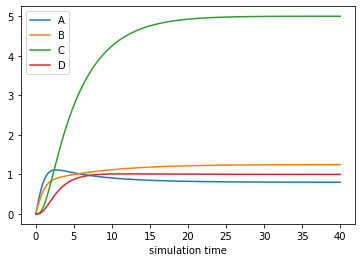

===== STABILITY ANALYSIS =====
The stability analysis is only valid for steady states. 

Jacobian at time=40.0 
[[-1.24826744 -0.80125846  0.          0.        ]
 [-0.62413372 -0.60062923  0.          0.        ]
 [ 1.24826744  0.80125846 -0.2         0.        ]
 [ 0.62413372  0.40062923  0.         -0.5       ]]


Eigen values
[-0.2        -0.5        -1.70223444 -0.14666222]


Eigen vectors
[[ 0.          0.         -0.56739642  0.30869419]
 [ 0.          0.         -0.32146837 -0.42440628]
 [ 1.          0.          0.64293675  0.84881257]
 [ 0.          1.          0.4016861   0.06406586]]


4 4
All eigenvalues have negative real parts, 
the steady state is asymptotically stable


True

In [21]:
#create a new model
example_01 = Model()
#load the system definition file into the model
example_01.load("example_01.txt")
#explain the model species and reactions
example_01.explain()

#provide initial conditions for the species abundencies
X0 = [0,0,0,0]
#simulate the system by numerical integration
run = example_01.simulate(X0,40)

#plot the resulting solution
ax = plt.gca()
run.plot(["A","B","C","D"],ax)
ax.set_xlabel("simulation time")
plt.legend()
plt.show()

run.printStability()

#### 2.2.2 Michaelis Menten kinetics
Reactions catalyzed by enzymes can be described by the Michaelis Menten kinetic. These type of kinetics take into account the affinity of the enzyme towards the substrate, which is defined by a concentration of half maximum reaction rate.<br>
<br>
The definition of the reaction is depending on the limiting substrate species $[S]$, the substrate concentration of half maximum velocity $K_m$ and the maximum rate $V_{max}$. The maximum rate can further depend on the variable enzyme concentration $[E]$: $ V_{max} = k_{cat} [E]$.

$$
v =  V_{max} \frac{ [S]}{K_m + [S]}
 =  k_{cat} [E]\frac{ [S]}{K_m + [S]}
$$

From there one can derive differential equations, which describe the change of the species. Reactions with michaelis menten kinetics can be implemented in the system definition with the following syntax:
```
S, P, ENZYME
#SUBSTRATE -M-{V_max},{K_M}-> PRODUCT # Comment or reaction description
#SUBSTRATE -M-{k_cat},{K_M},{ENZYME}-> PRODUCT # Comment or reaction description

S -M-1,0.2-> P # Michaelis menten kinetic
S -M-1,0.2,ENZYME-> P # Michaelis menten kinetic with variable enzyme concentration

```
<br>

#### 2.2.3 Michaelis Menten kinetics with allosteric activation
The Michaelis Menten kinetic can be expanded to account for allosteric activation.<br>
This kinetic model assumes two states of the enzyme, an inactive enzyme species without the bound activating molecule, and an activated state with the bound activator.The activator molecule is binding in an allosteric manner, which means there is no competition with the substrate molecule.<br>
<br>
In addition to the parameters of the regular Michaelis Menten kinetic, this kinetic is also depending on the activator concentration $[A]$ and the activator concentration of half activation $K_a$.

$$
v =  V_{max}\frac{[S]}{K_m + [S]} \frac{[A]}{K_a + [A]} 
$$

This can be implemented in the system definition with the following syntax:
```
S, P, ACTIVATOR
#SUBSTRATE -A-{V_max},{K_M},{K_a},{ACTIVATOR}-> PRODUCT # Comment or reaction description

S -A-4,0.01,0.5,ACTIVATOR-> P
```
<br>

#### 2.2.4 Michaelis Menten kinetics with allosteric inhibition
The same can be implemented with allosteric inhibition. In this case, the binding of an allosteric inhibitory ligand inactivates the enzyme activity.<br><br>
The inhibition is likewise depending on the inhibitor concentration of half inhibition $K_i$ and and the inhibitor species concentration $[I]$.
$$
v =  V_{max}\frac{[S]}{K_m + [S]} (1-\frac{[I]}{K_i + [I]})
$$

This can be implemented in the system definition with the following syntax:
```
S, P, INHIBITOR
#SUBSTRATE -I-{V_max},{K_M},{K_i},{INHIBITOR}-> PRODUCT # Comment or reaction description

S -I-4,0.01,0.5,INHIBITOR-> P
```
<br>

#### 2.2.5 Cooperative Enzyme kinetics
Enzymes with multiple binding sites or multimeric enzyme complexes can have cooperative or anti-cooperative effects. This kinetic can be described by the Hill equation which is dependent on the substrate concentration at half activity $K_a$ and the measure of cooperativity, the hill constant $h$.<br><br>
Binding of the first substrate molecule either increases ($h > 1$) or decreases ($h < 1$) the affinity towards the next substrate molecule in adjecent binding sides.
$$
v =  V_{max}\frac{[S]^h}{K_a^h + [S]^h}
$$

This can be implemented in the system definition with the following syntax:
```
S, P
# SUBSTRATE -H-{V_max},{K_a},{hill_coefficient}-> PRODUCT # Comment or reaction description

S -H-4,0.4,4,INHIBITOR-> P
```
<br>

### 2.3 Biochemical examples
#### 2.3.1 Glycolysis Pathway
Based on this toolbox, small scale systems can be described and modeled. In this first example the conversion of Glucose to Pyruvate and ATP in the glycolisis pathway of a prokaryote is simulated. The system behaviour is shaped by the specific pacemaker reactions of the phosphotransferase system for the phosphorilation and transfer of glucose and the feed forward activation of the phosphofructo kinase by Fructose1,6 bisphosphate [3]. This model is not biologically accurate but can be used to outline the behaviour of the system emerging from these reactions.
```
GLUCOSE, PEP, ATP, PYRUVATE, P, GLUCOSEP, FRUCTOSEP, PFRUCTOSEP, DHAP, GAP, BPG, PG

# Michaelis Menten kinetics:                 SUBSTRATE -M-{V_max},{K_M}-> PRODUCT
# MM kinetics with allosteric inhibition:    SUBSTRATE -I-{V_max},{K_M},{K_i},{INHIBITOR}-> PRODUCT
# MM kinetics with allosteric activation:    SUBSTRATE -A-{V_max},{K_M},{K_a},{ACTIVATOR}-> PRODUCT
# Hill cooperative kinetic:                  SUBSTRATE -H-{V_max},{K_a},{hill_coefficient}-> PRODUCT
# Stoichometric reaction:                    EDUKT + EDUKT -S-{k}-> PRODUCT + PRODUCT

#-S-2-> A #Influx of A


-S-0.02-> GLUCOSE

PEP -I-0.2,2,2,P-> PYRUVATE + P
P + GLUCOSE -S-0.1-> GLUCOSEP

GLUCOSEP -S-1-> FRUCTOSEP
FRUCTOSEP -S-1-> GLUCOSEP

FRUCTOSEP + ATP -A-2,2,2,5,ATP-> PFRUCTOSEP

PFRUCTOSEP -S-2-> DHAP + GAP
DHAP + GAP -S-2-> PFRUCTOSEP

DHAP -S-2-> GAP
GAP -S-2-> DHAP

GAP -S-2-> BPG
BPG -S-2-> GAP

BPG -M-1,2-> ATP + PG
PG + ATP -S-0.02-> BPG

PG -S-0.2-> PEP
PEP -S-0.2-> PG


PEP -A-1,0.5,0.5,PFRUCTOSEP-> ATP + PYRUVATE

PYRUVATE -S-0.3->
ATP -S-0.1->
```

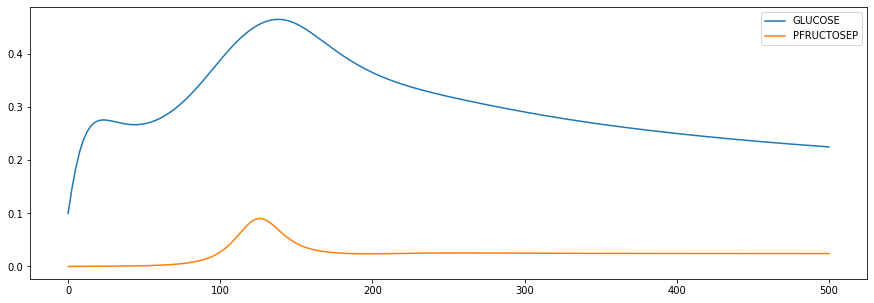

In [12]:
X0 = [0.1,2, 0.1, 0, 0,0,0,0.0001,0,0,0,0]

model = Model()
model.load("glycolisis.txt")

initial = model.simulate(X0,500)
ax = plt.gca()
ax.set_prop_cycle(None)
initial.plot(["GLUCOSE",  "PFRUCTOSEP"],ax)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.legend()
plt.show()

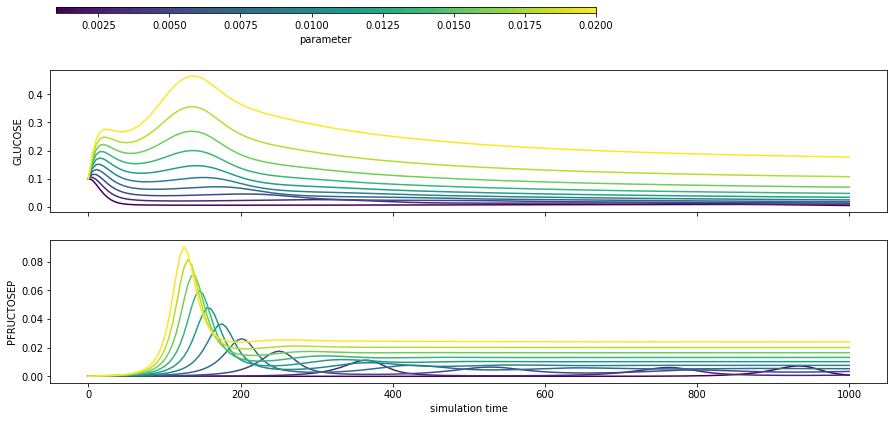

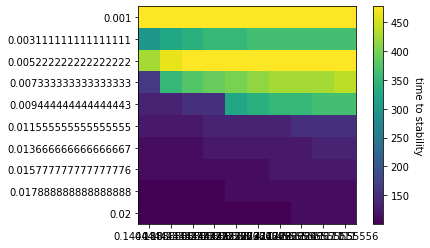

[[477.38693467 477.38693467 477.38693467 477.38693467 477.38693467
  477.38693467 477.38693467 477.38693467 477.38693467 477.38693467]
 [301.50753769 326.63316583 339.1959799  351.75879397 351.75879397
  364.32160804 364.32160804 364.32160804 364.32160804 364.32160804]
 [427.13567839 464.8241206  477.38693467 477.38693467 477.38693467
  477.38693467 477.38693467 477.38693467 477.38693467 477.38693467]
 [163.31658291 351.75879397 376.88442211 389.44723618 402.01005025
  414.57286432 427.13567839 427.13567839 427.13567839 439.69849246]
 [138.19095477 138.19095477 150.75376884 150.75376884 326.63316583
  339.1959799  351.75879397 351.75879397 364.32160804 364.32160804]
 [125.6281407  125.6281407  125.6281407  138.19095477 138.19095477
  138.19095477 138.19095477 150.75376884 150.75376884 150.75376884]
 [113.06532663 113.06532663 113.06532663 125.6281407  125.6281407
  125.6281407  125.6281407  125.6281407  138.19095477 138.19095477]
 [113.06532663 113.06532663 113.06532663 113.06532663 11

In [13]:
# ==== Warning, this can take very long to compute! ====
X0 = [0.1,2, 0.1, 0, 0,0,0,0.0001,0,0,0,0]
speciesToPlot = ["GLUCOSE","PFRUCTOSEP"]

model = Model()
model.load("glycolisis.txt")

Glyc_Sampler = Sampler(model)
Glyc_Sampler.plotFunctionFamily(X0, 1000, 0, np.linspace(0.001,0.02,10),speciesToPlot)
Glyc_Sampler.plotStability(X0, 500, [0,1], [np.linspace(0.001,0.02,10),np.linspace(0.1,0.5,10)])

#### 2.3.2 Cell cycle and Cyclin degradation
The complex behaviour emerging from a set of simple reactions can be seen in this broad model of the cell cycle [4]. The combination of Cycline, a cycline dependent kinase (CDC2) and the anaphase promating complex as proxy for the replication leads to stable oscillation. The dependence on the parameters can be analysed.
```
CYCLINE, ACDC, ICDC, AAPC, IAPC

# Michaelis Menten kinetics:                 SUBSTRATE -M-{V_max},{K_M}-> PRODUCT
# MM kinetics with allosteric inhibition:    SUBSTRATE -I-{V_max},{K_M},{K_i},{INHIBITOR}-> PRODUCT
# MM kinetics with allosteric activation:    SUBSTRATE -A-{V_max},{K_M},{K_a},{ACTIVATOR}-> PRODUCT
# Hill cooperative kinetic:                  SUBSTRATE -H-{V_max},{K_a},{hill_coefficient}-> PRODUCT
# Stoichometric reaction:                    EDUKT + EDUKT -S-{k}-> PRODUCT + PRODUCT

-S-0.06-> CYCLINE
CYCLINE -S-0.001->
CYCLINE -M-0.25,0.01,AAPC->

ACDC -M-2,0.01-> ICDC
ICDC -A-4,0.01,0.5,CYCLINE-> ACDC

AAPC -M-0.7,0.01-> IAPC
IAPC -M-1,0.01,ACDC-> AAPC
```

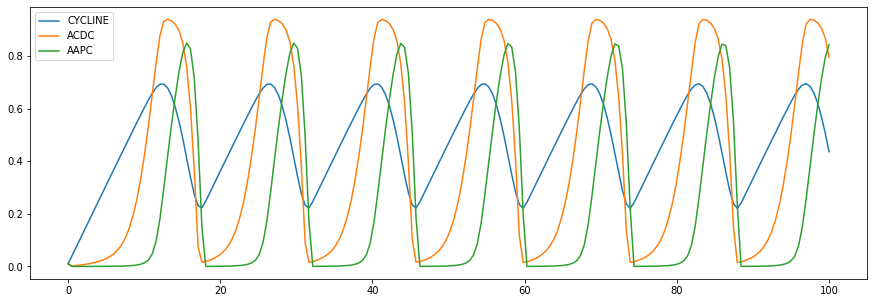

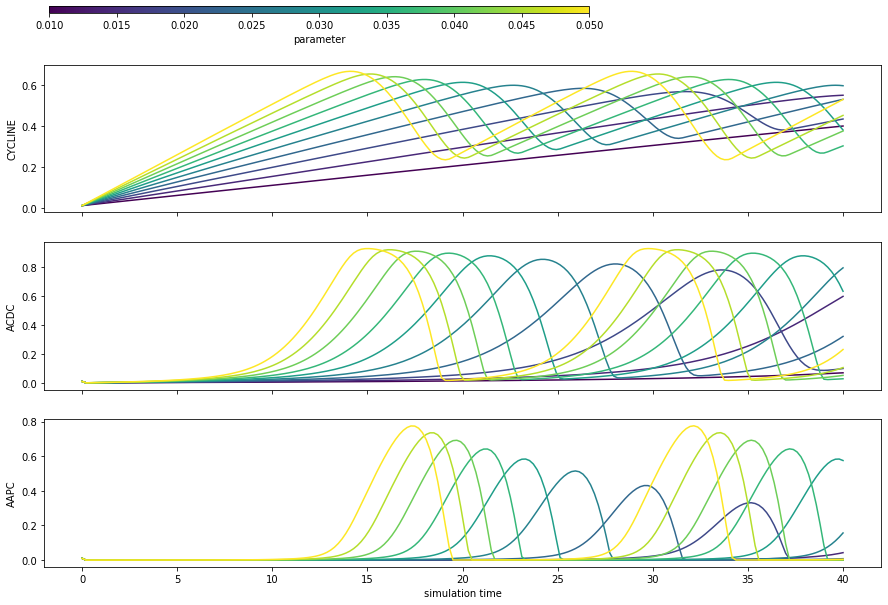

In [22]:
model = Model()
model.load("cell_cycle.txt")
#model.explain()

X0 = [0.01,0.01,0.99,0.01,0.99]
ax = plt.gca()
fig = plt.gcf()
ax.set_prop_cycle(None)
initial = model.simulate(X0,100)
initial.plot(["CYCLINE","ACDC","AAPC"],ax)
fig.set_size_inches(15, 5)
plt.legend()
plt.show()

speciesToPlot = ["CYCLINE","ACDC","AAPC"]

model = Model()
model.load("cell_cycle.txt")

Glyc_Sampler = Sampler(model)
Glyc_Sampler.plotFunctionFamily(X0, 40, 0, np.linspace(0.01,0.05,10),speciesToPlot)


[0] Voit, Eberhardt O. (2000), Computational Analysis of Biochemical Systems: A Practical Guide for Biochemists and Molecular Biologists, Cambridge University Press<br>
[1] Szallasi, Zoltan and Stelling, Jörg and Periwal, Vipul (2006), System Modeling in Cellular Biology, MIT Press<br>
[2] Hoops S., Sahle S., Gauges R., Lee C., Pahle J., Simus N., Singhal M., Xu L., Mendes P. and Kummer U. (2006). COPASI: a COmplex PAthway SImulator. Bioinformatics 22, 3067-74.<br>
[3] Berg, J.M. and Held, A. and Stryer, L. and Lange, C. and Mahlke, K. and Maxam, G. and Seidler, L. and Zellerhoff, N. and Häcker, B. and Jarosch, B. and others (2012) Stryer Biochemie, Springer Berlin Heidelberg<br>
[4] Goldbeter, Albert (2013), Oscillatory enzyme reactions and Michaelis–Menten kinetics, FEBS Letters, 587, doi: 10.1016/j.febslet.2013.07.031<br>